In [1]:
# https://enveritas.looker.com/explore/pipeline_analytics/coffee_cross_country_ops_data?qid=1ZsRBUvzftJJDyPdOFFXIS

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv('../data/_local/farm_sizes.csv')
df.columns = ['country', 'plots', 'farm_size', 'production', 'count']
df.dropna(inplace=True)

df['yield'] = df['production'] / df['farm_size']
df = df[df['yield'].between(50,5000)]

df.tail()

,country,plots,farm_size,production,count,yield
54213,Colombia,4.0,2.8,1600.00,1,571.428571
54214,Colombia,4.0,2.8,3918.75,1,1399.553571
54215,Colombia,4.0,2.9,337.50,1,116.379310
54216,Colombia,4.0,3.0,220.00,1,73.333333
54217,Colombia,4.0,3.0,300.00,1,100.000000


In [4]:
df["avg_plot_size"] = df["farm_size"] / df["plots"]
df["plots_category"] = df["plots"].apply(lambda x: x if x <= 10 else 10)
df["production_per_plot"] = df["production"] / df["plots"]
df["plots_above_4ha"] = (df["avg_plot_size"] > 4) * df["count"] * df['plots']
df["plots_below_4ha"] = (df["avg_plot_size"] <= 4) * df["count"] * df['plots']
df['production_total'] = df['production'] * df['count']

df.tail()

,country,plots,farm_size,production,count,yield,avg_plot_size,plots_category,production_per_plot,plots_above_4ha,plots_below_4ha,production_total
54213,Colombia,4.0,2.8,1600.00,1,571.428571,0.700,4.0,400.0000,0.0,4.0,1600.00
54214,Colombia,4.0,2.8,3918.75,1,1399.553571,0.700,4.0,979.6875,0.0,4.0,3918.75
54215,Colombia,4.0,2.9,337.50,1,116.379310,0.725,4.0,84.3750,0.0,4.0,337.50
54216,Colombia,4.0,3.0,220.00,1,73.333333,0.750,4.0,55.0000,0.0,4.0,220.00
54217,Colombia,4.0,3.0,300.00,1,100.000000,0.750,4.0,75.0000,0.0,4.0,300.00


In [5]:
NUM_FARMERS = 12_500_000
num_surveys = df['count'].sum()
num_surveys

77044

In [6]:
# est farmers with more than 4 ha globally
(df[df['farm_size'] >= 4]['count'].sum() * (NUM_FARMERS / num_surveys)) / 1_000_000

0.8827747780489071

In [7]:
# est production from larger farms
total_production = df['production_total'].sum() 
prod_from_farms_above_4ha = df[df['farm_size'] >= 4]['production_total'].sum()
prod_from_farms_above_4ha / total_production

0.7076728816481018

In [8]:
# average plots per farmer, globally
(df['count'] * df['plots']).sum() / df['count'].sum()

1.9151264212657702

In [9]:
print(df[df['plots'] >= 3]['count'].sum() / num_surveys)
print(df[df['plots'] >= 5]['count'].sum() / num_surveys)
print(df[df['plots'] == 1]['count'].sum() / num_surveys)

0.20185867815793573
0.04681740304241732
0.53697886921759


In [10]:
country_estimates = df.groupby("country")[["plots_above_4ha", "plots_below_4ha"]].sum()
country_estimates

,plots_above_4ha,plots_below_4ha
country,,
Australia,0.0,1.0
Bolivia,2.0,189.0
Brazil,2575.0,11794.0
Burundi,0.0,14413.0
Colombia,388.0,9837.0
Costa Rica,133.0,943.0
Côte d'Ivoire,50.0,1802.0
Dem. Rep. Congo,0.0,310.0
Ecuador,3.0,250.0


In [11]:
# estimated global plots distribution (MILLIONS)
(country_estimates.sum(axis=0) * (NUM_FARMERS / num_surveys)) / 1_000_000

plots_above_4ha     0.683213
plots_below_4ha    23.255867
dtype: float64

<Axes: title={'center': "Distribution of the World's >4ha Plots"}, xlabel='country'>

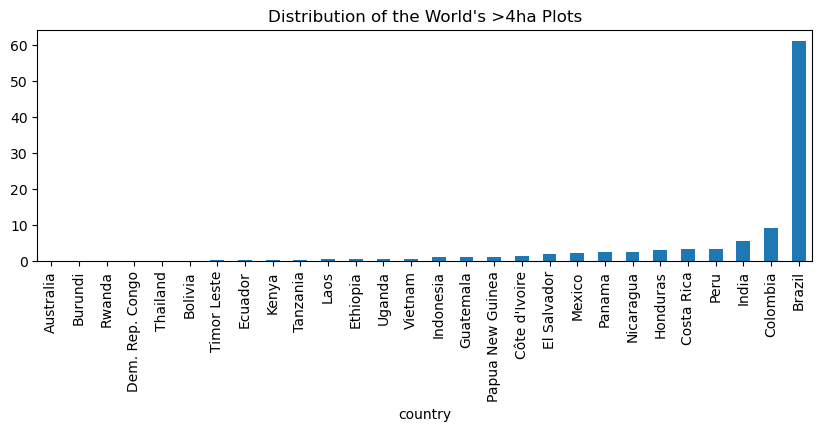

In [12]:
plt.figure(figsize=(10, 3))
(
    (
        country_estimates['plots_above_4ha'].sort_values()
        / country_estimates['plots_above_4ha'].sum() * 100
    )
    .plot(kind='bar', title="Distribution of the World's >4ha Plots")
)

<Axes: title={'center': "Distribution of the World's <4ha Plots"}, xlabel='country'>

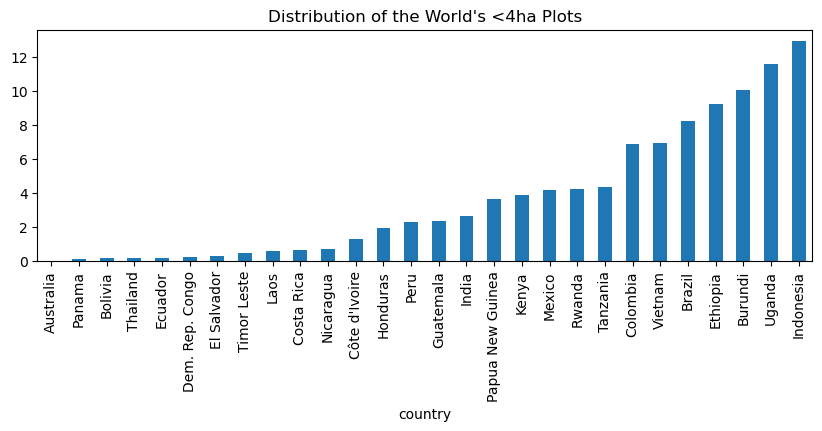

In [13]:
plt.figure(figsize=(10, 3))
(
    (
        country_estimates['plots_below_4ha'].sort_values()
        / country_estimates['plots_below_4ha'].sum() * 100
    )
    .plot(kind='bar', title="Distribution of the World's <4ha Plots")
)

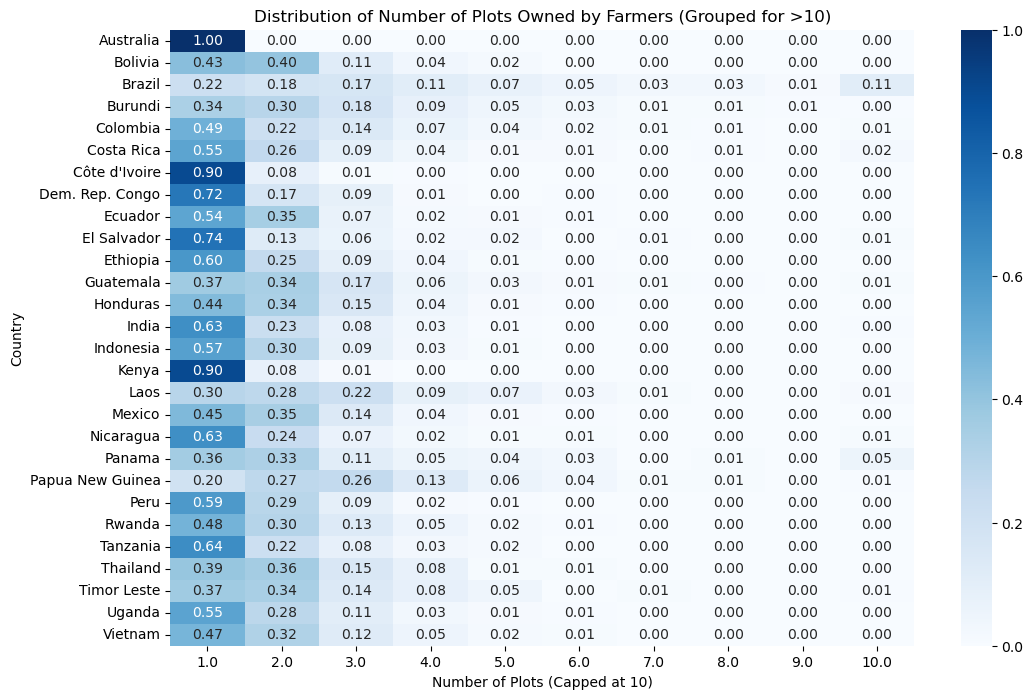

In [14]:
plot_distribution = df.groupby(["country", "plots_category"])["count"].sum().unstack(fill_value=0)
plot_distribution_normalized = plot_distribution.div(df.groupby("country")["count"].sum(), axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(plot_distribution_normalized, cmap="Blues", annot=True, fmt=".2f")
plt.title("Distribution of Number of Plots Owned by Farmers (Grouped for >10)")
plt.xlabel("Number of Plots (Capped at 10)")
plt.ylabel("Country")
plt.show()

In [15]:
correlation = df[["plots", "farm_size"]].corr().iloc[0, 1]
correlation

0.41729533806173286

(0.0, 1.0)

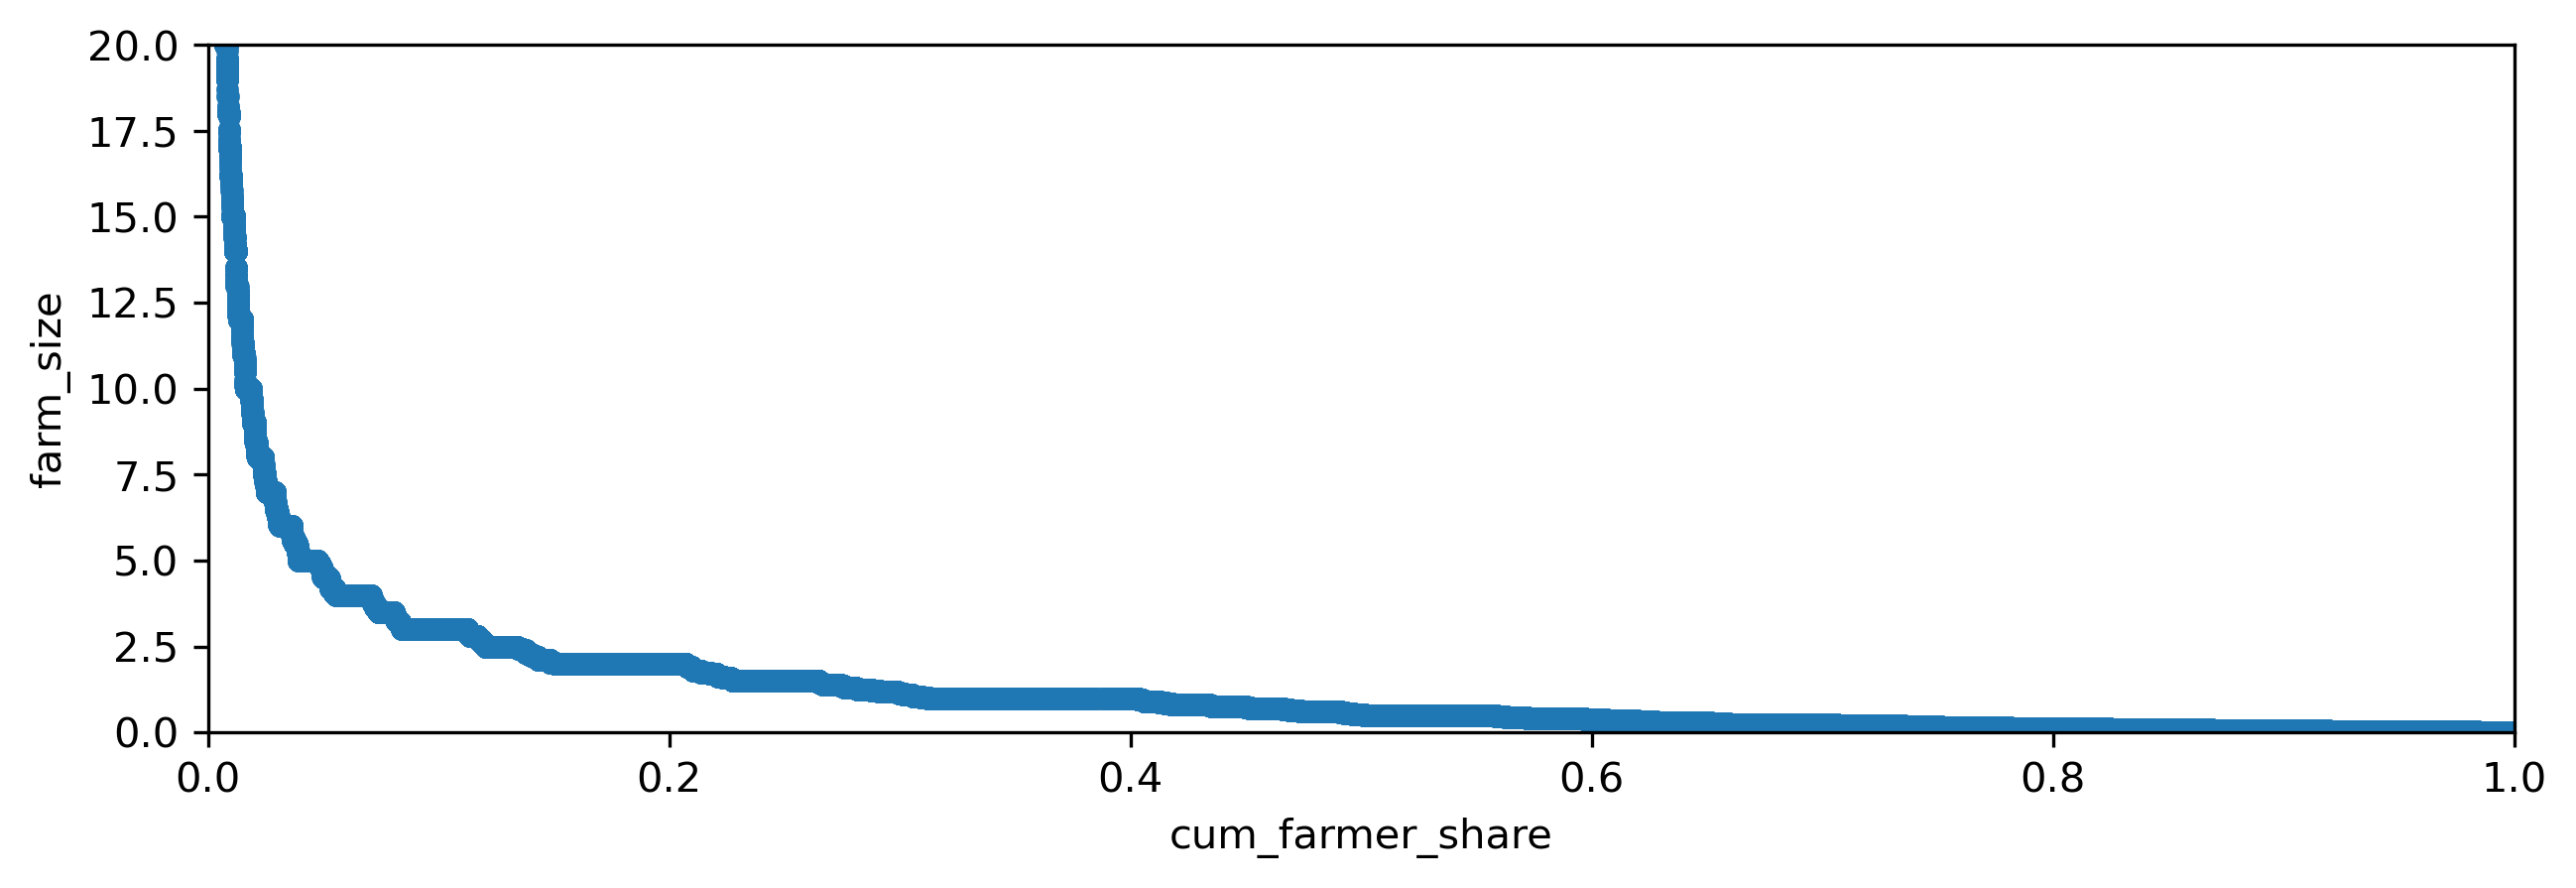

In [16]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
df_sorted = df[['farm_size', 'count']].sort_values(by='farm_size', ascending=False).dropna().copy()
df_sorted['farmer_share'] = df_sorted['count'] / num_surveys
df_sorted['cum_farmer_share'] = df_sorted['farmer_share'].cumsum()
df_sorted.plot(kind='scatter', x='cum_farmer_share', y='farm_size', ax=ax)
ax.set_ylim(0,20)
ax.set_xlim(0,1)
#ax.set_xticks([.25,.5,.75])
#ax.axhline(4, color='black')

(0.0, 1.0)

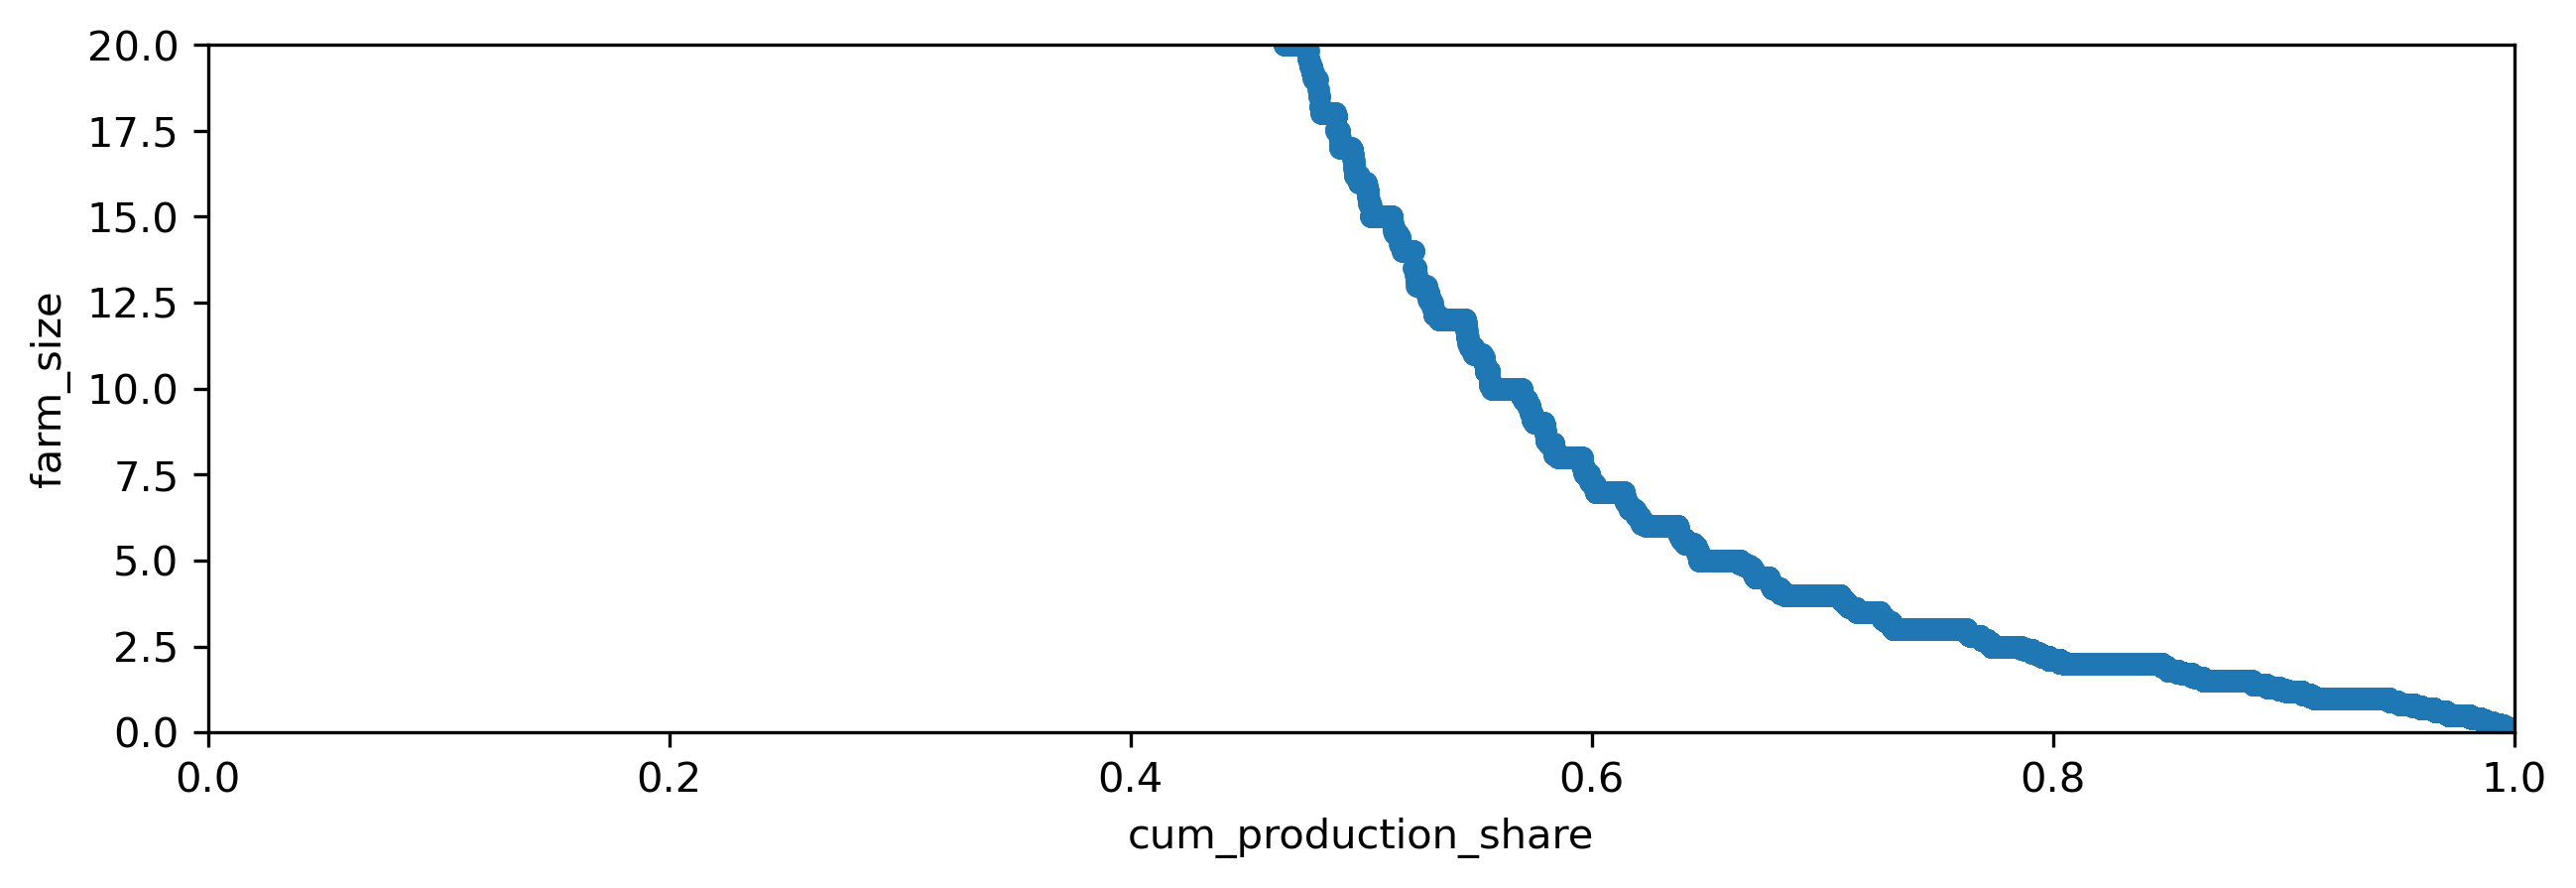

In [17]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
df_sorted = df[['farm_size', 'production_total', 'count']].sort_values(by='farm_size', ascending=False).dropna().copy()
df_sorted['production_share'] = df_sorted['production_total'] / total_production
df_sorted['cum_production_share'] = df_sorted['production_share'].cumsum()
df_sorted.plot(kind='scatter', x='cum_production_share', y='farm_size', ax=ax)
ax.set_ylim(0,20)
ax.set_xlim(0,1)
#ax.set_xticks([.25,.5,.75])
#ax.axhline(4, color='black')

In [18]:
total_production = df['production_total'].sum() 
prod_from_plots_above_4ha = df[df['plots_above_4ha'] > 0]['production_total'].sum()
prod_from_plots_above_4ha / total_production

0.46929252117201464

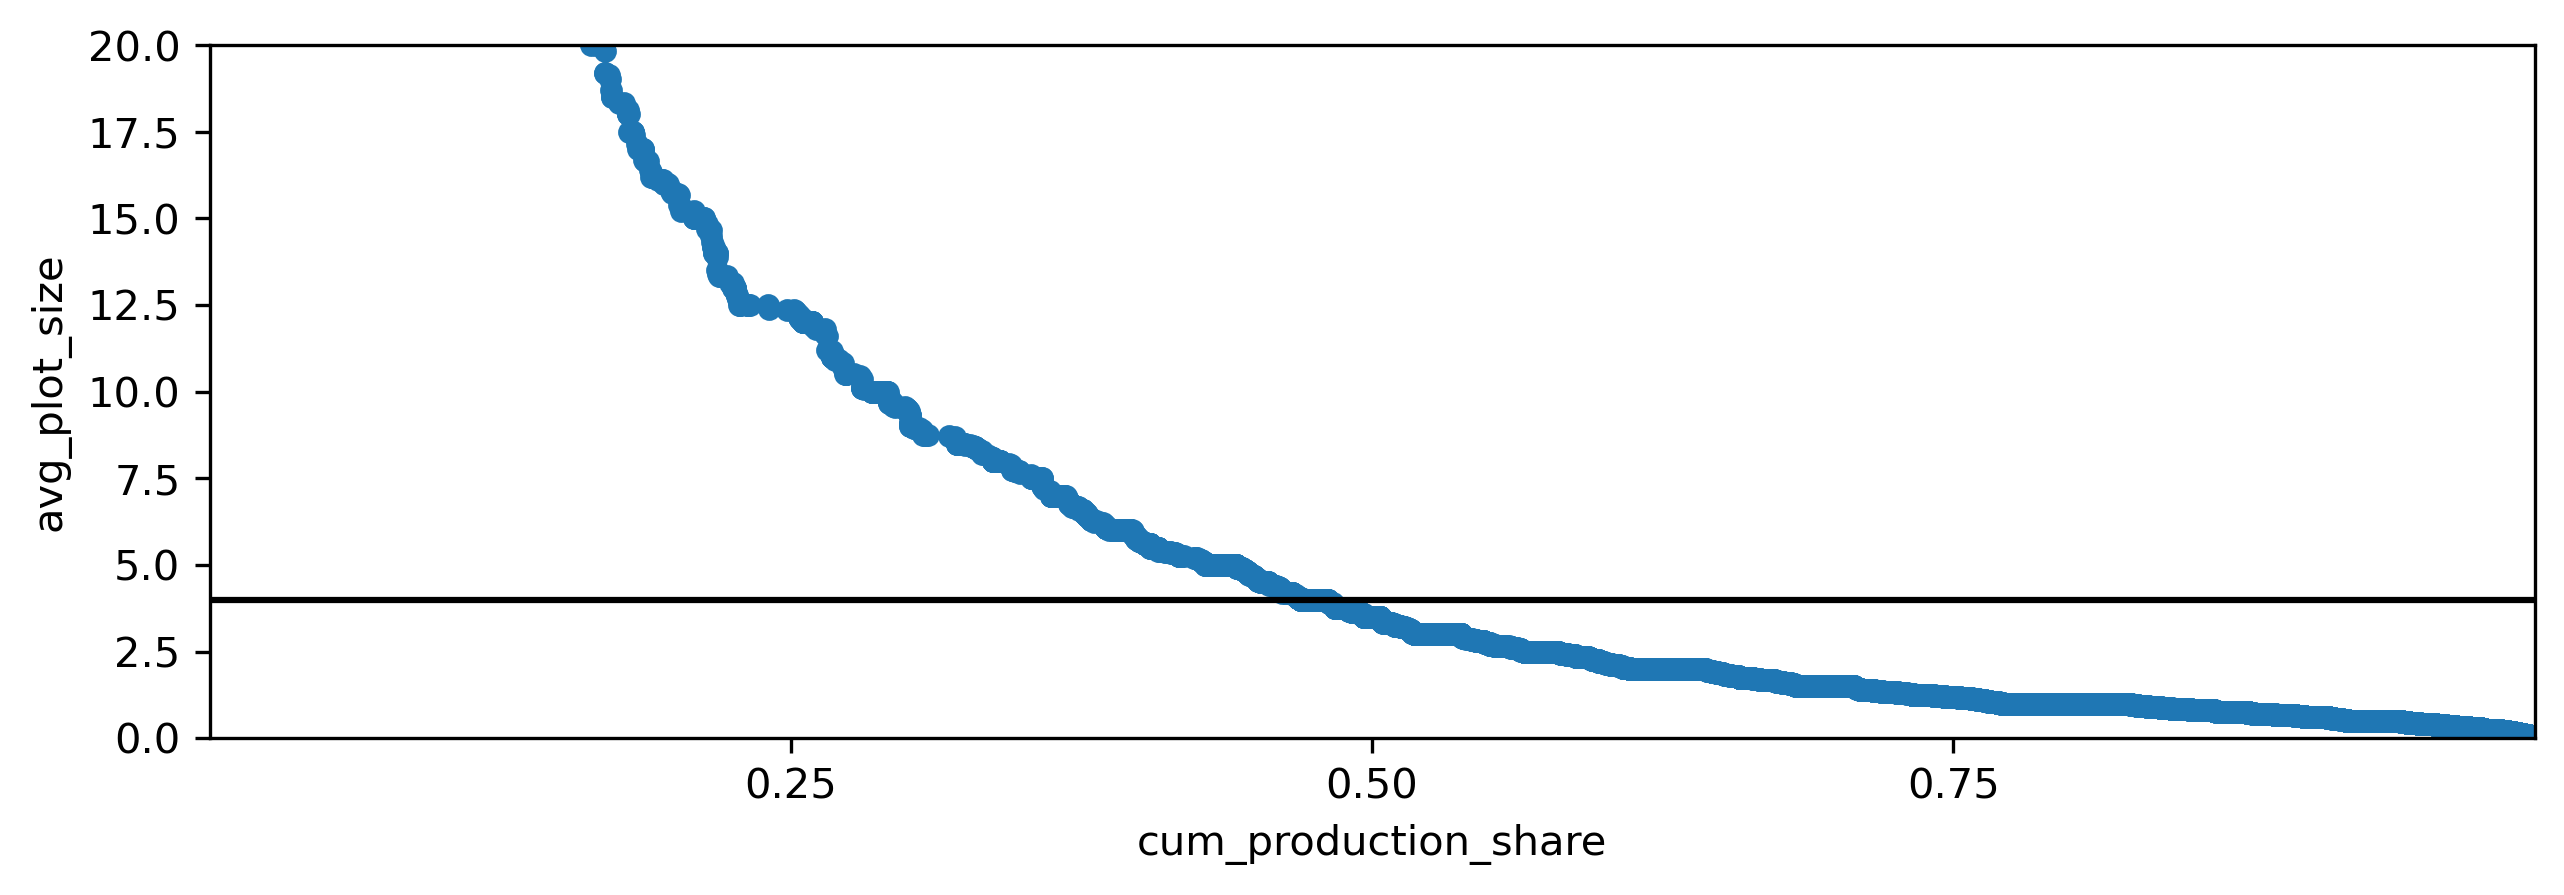

In [19]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
df_sorted = df[['avg_plot_size', 'production_total', 'count']].sort_values(by='avg_plot_size', ascending=False).dropna().copy()
df_sorted['production_share'] = df_sorted['production_total'] / total_production
df_sorted['cum_production_share'] = df_sorted['production_share'].cumsum()
df_sorted.plot(kind='scatter', x='cum_production_share', y='avg_plot_size', ax=ax)
ax.set_ylim(0,20)
ax.set_xlim(0,1)
ax.set_xticks([.25,.5,.75])
ax.axhline(4, color='black')